# Hilbert-Huang Transform (HHT) 解析チュートリアル

このチュートリアルでは、**gwexpy** を使用した **Hilbert-Huang Transform (HHT)** 解析の手順を解説します。
HHT は、非線形・非定常な信号の解析に適しており、従来のフーリエ変換やウェーブレット変換では捉えきれない局所的な周波数変動（瞬時周波数）を抽出するのに強力な手法です。

HHT は以下の2つの主要なステップから成ります：
1.  **Empirical Mode Decomposition (EMD)**: 信号を固有モード関数 (IMF: Intrinsic Mode Function) に分解します。
2.  **Hilbert Spectral Analysis**: 各 IMF に対してヒルベルト変換を行い、瞬時振幅と瞬時周波数を計算します。

**注意**: この機能を使用するには `PyEMD` (EMD-signal) パッケージがインストールされている必要があります。
```bash
pip install EMD-signal
```

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from gwexpy.timeseries import TimeSeries

# PyEMDの確認
try:
    import PyEMD

    print(f"{PyEMD.__name__} is installed and ready.")
except ImportError:
    raise ImportError(
        "このチュートリアルには 'PyEMD' (EMD-signal) が必要です。 pip install EMD-signal を実行してください。"
    )

PyEMD is installed and ready.


## 1. シミュレーションデータの作成

EMD の効果を確認するために、以下の特徴を持つ非定常な合成信号を作成します。
1.  **低周波トレンド**: 5 Hz の正弦波
2.  **チャープ信号**: 時間とともに周波数が上昇する成分 (〜100 Hz)
3.  **線形トレンド**: 直線的なドリフト

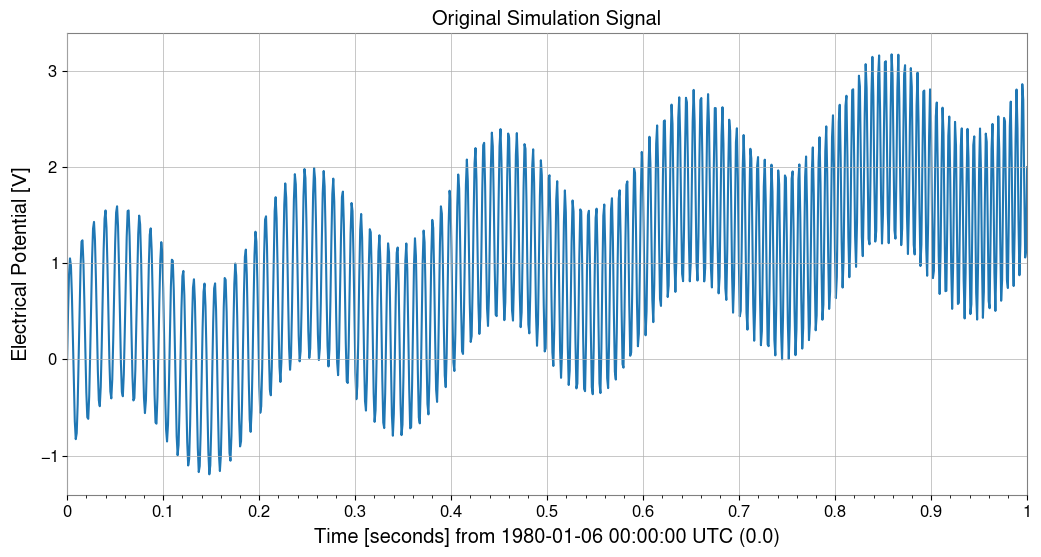

In [2]:
# 時間軸 (1秒間、1000サンプル)
t = np.linspace(0, 1, 1000)
dt = t[1] - t[0]

# 信号成分
s1 = 0.5 * np.sin(2 * np.pi * 5 * t)  # 低周波
s2 = 1.0 * np.sin(2 * np.pi * 80 * t * (1 + 0.5 * t))  # チャープ (80Hz -> 120Hz)
trend = 2.0 * t  # 線形トレンド

# TimeSeriesオブジェクトの作成
data = TimeSeries(s1 + s2 + trend, dt=dt, unit="V", name="Simulation Data")

# プロット
plot = data.plot(title="Original Simulation Signal")
plot.show()

## 2. Empirical Mode Decomposition (EMD)

`gwexpy` の `TimeSeries` オブジェクトは、`emd()` メソッドを通じて直接分解を行うことができます。
`emd()` メソッドは `PyEMD` ラッパーとして機能し、結果を `TimeSeriesDict` として返します。

ここでは基本的な **EMD** を使用しますが、オプションで **EEMD (Ensemble EMD)** も選択可能です。

抽出されたIMF: ['IMF1', 'IMF2', 'IMF3', 'residual']


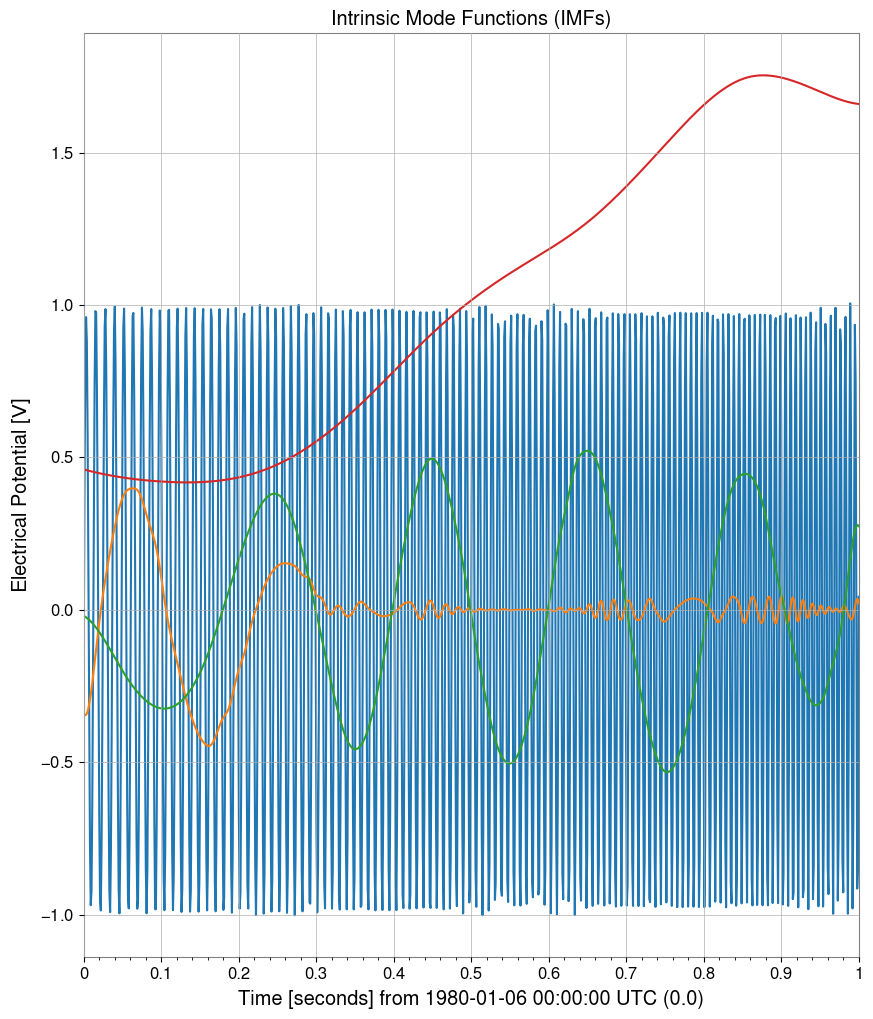

In [3]:
# EMDの実行
# method='eemd' とすると Ensemble EMD が実行されます (計算時間がかかります)
imfs = data.emd(method="emd")

print("抽出されたIMF:", list(imfs.keys()))

# 全IMFをプロット
plot = imfs.plot(figsize=(10, 12), sharex=True, title="Intrinsic Mode Functions (IMFs)")
plot.show()

プロットを見ると、信号が異なる周波数帯域ごとのモード (IMF) に分解されていることがわかります。
*   **IMF 0**: 最も高周波な成分（チャープ信号の一部やノイズ）
*   **IMF 1, 2...**: より低周波な成分
*   **Residual**: 残差（トレンド成分）

---

## 3. ヒルベルトスペクトル解析

各 IMF は「単一成分」に近い性質を持つため、ヒルベルト変換を適用することで物理的に意味のある**瞬時周波数 (Instantaneous Frequency)** と **瞬時振幅 (Instantaneous Amplitude)** を定義できます。

`gwexpy` の `TimeSeries` は以下のメソッドを提供しています：
*   `.hilbert()`: 解析信号 (Analytic Signal) を計算
*   `.instantaneous_frequency()`: 瞬時周波数を計算 (位相の微分)
*   `.envelope()`: 包絡線（瞬時振幅）を計算

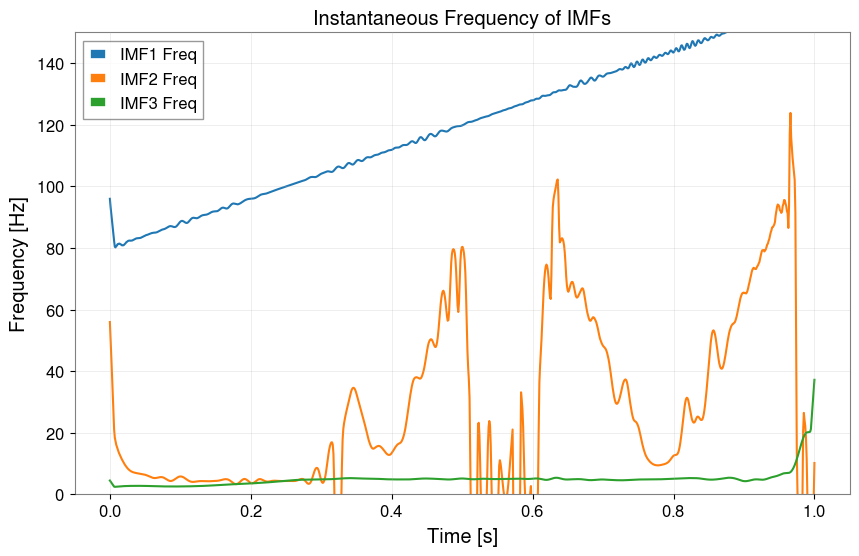

In [4]:
# 解析結果を格納する辞書
hht_results = {}

plt.figure(figsize=(10, 6))

# 最初の数個のIMFについて解析を行う
for key in list(imfs.keys())[:3]:  # Loop over first 3 IMFs
    imf = imfs[key]

    # 瞬時周波数の計算
    # smoothパラメータで微分のノイズを平滑化できます
    inst_freq = imf.instantaneous_frequency(smooth=10)

    # 瞬時振幅 (包絡線) の計算
    inst_amp = imf.envelope()

    hht_results[key] = {"freq": inst_freq, "amp": inst_amp}

    # 瞬時周波数の時間変化をプロット
    plt.plot(inst_freq.times.value, inst_freq.value, label=f"{key} Freq")

plt.title("Instantaneous Frequency of IMFs")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.ylim(0, 150)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 4. Hilbert Spectrum (ヒルベルトスペクトル)

最後に、これらの瞬時周波数と振幅を組み合わせて **ヒルベルトスペクトル** を描画します。
これは時間-周波数平面上でのエネルギー分布を表し、フーリエ変換ベースのスペクトログラムに相当しますが、時間・周波数分解能の制限（不確定性原理）を受けにくいという特徴があります。

ここでは、各サンプルの (時刻, 周波数) を点としてプロットし、色で振幅を表す散布図を使用します。

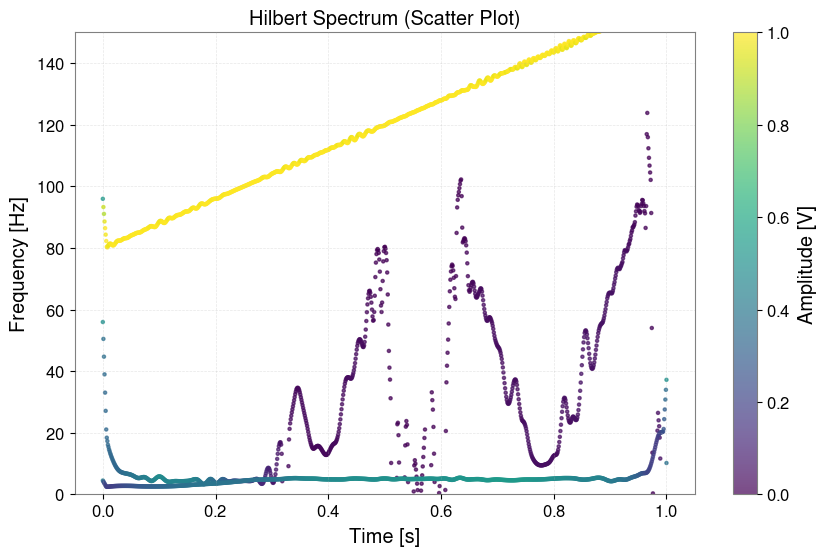

In [5]:
plt.figure(figsize=(10, 6))

for key, res in hht_results.items():
    t_vals = res["freq"].times.value
    f_vals = res["freq"].value
    a_vals = res["amp"].value

    # 周波数が負や極端に大きい値になることがあるためフィルタリング
    mask = (f_vals > 0) & (f_vals < 200)

    plt.scatter(
        t_vals[mask],
        f_vals[mask],
        c=a_vals[mask],
        cmap="viridis",
        s=5,
        alpha=0.7,
        vmin=0,
        vmax=1.0,
    )

plt.colorbar(label="Amplitude [V]")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.title("Hilbert Spectrum (Scatter Plot)")
plt.ylim(0, 150)
plt.grid(True, alpha=0.3, linestyle="--")
plt.show()

### 結果の解釈
ヒルベルトスペクトルでは、チャープ信号の周波数が時間とともに直線的に上昇している様子 (80Hz -> 120Hz) が非常に鮮明に確認できます。
低周波のIMFは下部に線として現れます。

このように、HHTは信号の非定常な振る舞いを詳細に分析するのに有効です。